In [ ]:
# 배추만

In [3]:
import os
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import TimeSeriesSplit

# 데이터 경로 설정
data_dir = '/content/sample_data'
file_path = os.path.join(data_dir, 'daily_average_price_volume_by_product_seoul.csv')

# 모델 저장 경로
saved_model_dir = '/content/saved_models'
os.makedirs(saved_model_dir, exist_ok=True)

# 데이터 로드
if not os.path.exists(file_path):
    raise FileNotFoundError(f"Data file not found at {file_path}")
data = pd.read_csv(file_path)

# 데이터 정렬
data['일자'] = pd.to_datetime(data['일자'])
data = data.sort_values(['품목', '일자'])

# 계절 원핫인코딩
onehot_encoder = OneHotEncoder(sparse_output=False)
seasons_encoded = onehot_encoder.fit_transform(data[['계절']])
season_columns = onehot_encoder.get_feature_names_out(['계절'])
season_df = pd.DataFrame(seasons_encoded, columns=season_columns)

# 원핫인코딩된 계절 추가
data = pd.concat([data.reset_index(drop=True), season_df.reset_index(drop=True)], axis=1)

# 성능 결과 저장용 리스트
performance_results = []

# 각 품목별로 처리
def preprocess_and_train(grouped_data, product_name):
    # 필요한 컬럼 선택
    feature_columns = ['총물량', '평균단가', '온도차(°C)', '평균기온(°C)', '일강수량(mm)'] + list(season_columns)
    data_subset = grouped_data[feature_columns]

    # 스케일링
    scaler = MinMaxScaler()
    scaled_data = scaler.fit_transform(data_subset)

    # 시계열 데이터 생성
    def create_sequences(data, seq_length):
        X, y = [], []
        for i in range(len(data) - seq_length):
            X.append(data[i:i+seq_length, :])
            y.append(data[i+seq_length, 1])  # 평균단가 예측
        return np.array(X), np.array(y)

    sequence_length = 30
    X, y = create_sequences(scaled_data, sequence_length)

    # TimeSeriesSplit for cross-validation
    tscv = TimeSeriesSplit(n_splits=5)
    fold = 1
    final_y_test, final_y_pred = None, None  # 마지막 fold 결과 저장
    for train_index, test_index in tscv.split(X):
        print(f"Processing fold {fold} for product: {product_name}")
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        # 모델 구성
        model = Sequential([
            LSTM(50, return_sequences=True, input_shape=(sequence_length, X.shape[2])),
            LSTM(50, return_sequences=False),
            Dense(25, activation='relu'),
            Dense(1)
        ])

        model.compile(optimizer='adam', loss='mse')

        # 체크포인트 설정
        checkpoint_path = os.path.join(saved_model_dir, f'{product_name}_fold{fold}_model.keras')
        checkpoint = ModelCheckpoint(checkpoint_path, save_best_only=True, monitor='val_loss', mode='min')

        # 모델 훈련
        model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=50, batch_size=32, callbacks=[checkpoint])

        # 성능 평가
        y_pred = model.predict(X_test)
        mse = mean_squared_error(y_test, y_pred)
        performance_results.append({"product": product_name, "fold": fold, "mse": mse})
        print(f"Performance for {product_name}, fold {fold}: MSE = {mse}")
        print(f"Model for {product_name}, fold {fold} saved at {checkpoint_path}")

        # 마지막 fold 결과 저장
        if fold == 5:
            final_y_test = y_test
            final_y_pred = y_pred

        fold += 1

    # 마지막 fold의 결과를 반환
    return final_y_test, final_y_pred

# 특정 품목만 선택
specific_product = "배추"
grouped = data.groupby('품목')

y_test, y_pred = None, None
for product, group in grouped:
    if product == specific_product:  # 특정 품목만 처리
        print(f"Processing product: {product}")
        y_test, y_pred = preprocess_and_train(group, product)

# 마지막 fold의 결과 저장
if y_test is not None and y_pred is not None:
    results_df = pd.DataFrame({"y_test": y_test.flatten(), "y_pred": y_pred.flatten()})
    results_path = os.path.join(saved_model_dir, 'lstm_results_baechu.csv')
    results_df.to_csv(results_path, index=False)
    print(f"Final fold results saved to {results_path}")

# 성능 결과 저장
performance_df = pd.DataFrame(performance_results)
performance_csv_path = os.path.join(saved_model_dir, 'performance_results.csv')
performance_df.to_csv(performance_csv_path, index=False)
print(f"Performance results saved to {performance_csv_path}")


Processing product: 배추
Processing fold 1 for product: 배추


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 77ms/step - loss: 0.0287 - val_loss: 0.0237
Epoch 2/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.0065 - val_loss: 0.0152
Epoch 3/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0073 - val_loss: 0.0169
Epoch 4/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - loss: 0.0067 - val_loss: 0.0151
Epoch 5/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 0.0061 - val_loss: 0.0144
Epoch 6/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - loss: 0.0041 - val_loss: 0.0131
Epoch 7/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - loss: 0.0044 - val_loss: 0.0123
Epoch 8/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.0054 - val_loss: 0.0116
Epoch 9/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.0046 - val_loss: 0.0129
Epoch 10/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.0061 - val_loss: 0.0125
Epoch 11/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - loss: 0.0061 - val_loss: 0.0123
Epoch 12/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - loss: 0.0

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


19/19 ━━━━━━━━━━━━━━━━━━━━ 4s 48ms/step - loss: 0.0146 - val_loss: 0.0095
Epoch 2/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0111 - val_loss: 0.0086
Epoch 3/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0076 - val_loss: 0.0069
Epoch 4/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - loss: 0.0064 - val_loss: 0.0060
Epoch 5/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 0.0059 - val_loss: 0.0074
Epoch 6/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.0061 - val_loss: 0.0072
Epoch 7/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.0047 - val_loss: 0.0074
Epoch 8/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.0063 - val_loss: 0.0057
Epoch 9/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.0054 - val_loss: 0.0059
Epoch 10/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.0057 - val_loss: 0.0067
Epoch 11/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.0058 - val_loss: 0.0059
Epoch 12/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0060 - val_l

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


29/29 ━━━━━━━━━━━━━━━━━━━━ 4s 39ms/step - loss: 0.0218 - val_loss: 0.0105
Epoch 2/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.0069 - val_loss: 0.0103
Epoch 3/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.0066 - val_loss: 0.0063
Epoch 4/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step - loss: 0.0070 - val_loss: 0.0065
Epoch 5/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 0.0059 - val_loss: 0.0065
Epoch 6/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.0055 - val_loss: 0.0059
Epoch 7/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 0.0055 - val_loss: 0.0071
Epoch 8/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.0053 - val_loss: 0.0056
Epoch 9/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 0.0055 - val_loss: 0.0079
Epoch 10/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 0.0062 - val_loss: 0.0064
Epoch 11/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 0.0054 - val_loss: 0.0059
Epoch 12/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 0.0048 - val_l

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


38/38 ━━━━━━━━━━━━━━━━━━━━ 5s 43ms/step - loss: 0.0345 - val_loss: 0.0082
Epoch 2/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.0097 - val_loss: 0.0073
Epoch 3/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 0.0071 - val_loss: 0.0067
Epoch 4/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 0.0057 - val_loss: 0.0066
Epoch 5/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.0060 - val_loss: 0.0067
Epoch 6/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 0.0061 - val_loss: 0.0065
Epoch 7/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - loss: 0.0053 - val_loss: 0.0077
Epoch 8/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - loss: 0.0055 - val_loss: 0.0062
Epoch 9/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - loss: 0.0053 - val_loss: 0.0061
Epoch 10/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.0059 - val_loss: 0.0061
Epoch 11/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 0.0049 - val_loss: 0.0063
Epoch 12/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 0.0050 - val_l

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


47/47 ━━━━━━━━━━━━━━━━━━━━ 5s 41ms/step - loss: 0.0302 - val_loss: 0.0082
Epoch 2/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 2s 42ms/step - loss: 0.0070 - val_loss: 0.0060
Epoch 3/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 2s 43ms/step - loss: 0.0060 - val_loss: 0.0063
Epoch 4/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step - loss: 0.0065 - val_loss: 0.0050
Epoch 5/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step - loss: 0.0062 - val_loss: 0.0054
Epoch 6/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - loss: 0.0057 - val_loss: 0.0059
Epoch 7/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.0059 - val_loss: 0.0049
Epoch 8/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 0.0061 - val_loss: 0.0050
Epoch 9/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 3s 37ms/step - loss: 0.0057 - val_loss: 0.0046
Epoch 10/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 0.0053 - val_loss: 0.0047
Epoch 11/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step - loss: 0.0055 - val_loss: 0.0045
Epoch 12/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - loss: 0.0050 - val_l

Performance for 배추, fold 1: MSE = 0.012534214994290914  
Performance for 배추, fold 2: MSE = 0.005659678368808653  
Performance for 배추, fold 3: MSE = 0.005371114982630179  
Performance for 배추, fold 4: MSE = 0.005534446063440755  
Performance for 배추, fold 5: MSE = 0.00411936503942601

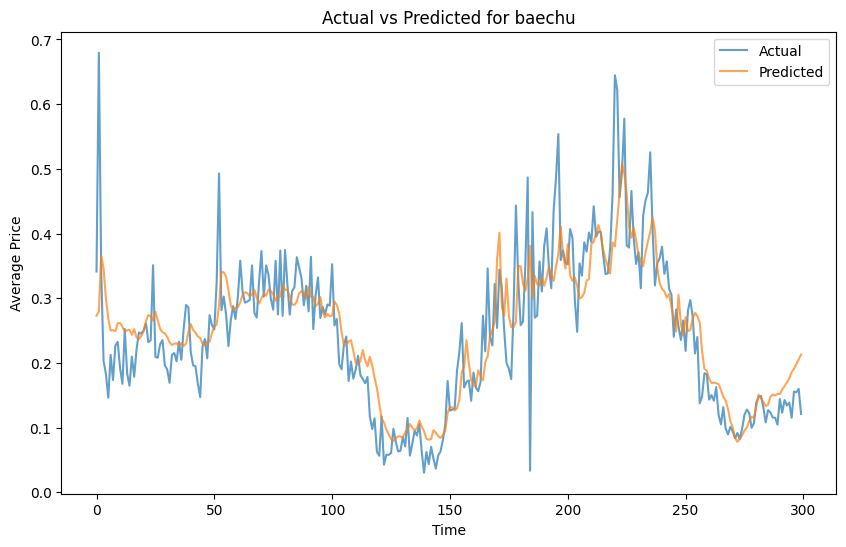

In [25]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(y_test.flatten(), label='Actual', alpha=0.7)
plt.plot(y_pred.flatten(), label='Predicted', alpha=0.7)
plt.legend()
plt.title('Actual vs Predicted for baechu')
plt.xlabel('Time')
plt.ylabel('Average Price')
plt.show()


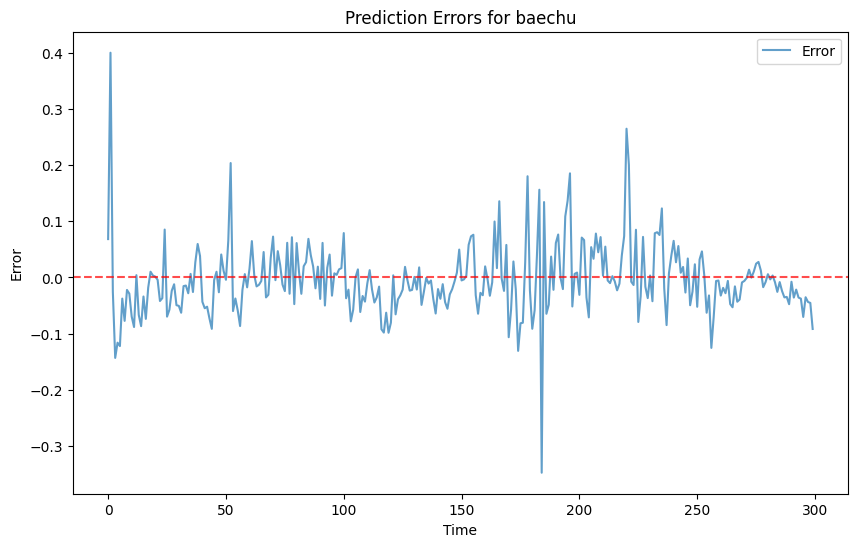

In [26]:
errors = y_test.flatten() - y_pred.flatten()

plt.figure(figsize=(10, 6))
plt.plot(errors, label='Error', alpha=0.7)
plt.title('Prediction Errors for baechu')
plt.xlabel('Time')
plt.ylabel('Error')
plt.axhline(0, color='red', linestyle='--', alpha=0.7)
plt.legend()
plt.show()


In [27]:
from tensorflow.keras.models import load_model

# 저장된 모델 경로
model_path = '/content/saved_models/배추_fold5_model.keras'

# 모델 로드
model = load_model(model_path)
print("Model loaded successfully!")


Model loaded successfully!


In [28]:
# 데이터 스케일링 및 시계열 데이터 생성
from sklearn.preprocessing import MinMaxScaler

# 필요한 컬럼 선택
feature_columns = ['총물량', '평균단가', '온도차(°C)', '평균기온(°C)', '일강수량(mm)'] + list(season_columns)
data_subset = data[data['품목'] == '배추'][feature_columns]

# 스케일링
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data_subset)

# 시계열 데이터 생성
def create_sequences(data, seq_length=30):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length, :])
        y.append(data[i+seq_length, 1])  # 평균단가 예측
    return np.array(X), np.array(y)

sequence_length = 30
X_test, y_test = create_sequences(scaled_data, sequence_length)
print("Test data prepared successfully!")


Test data prepared successfully!


57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


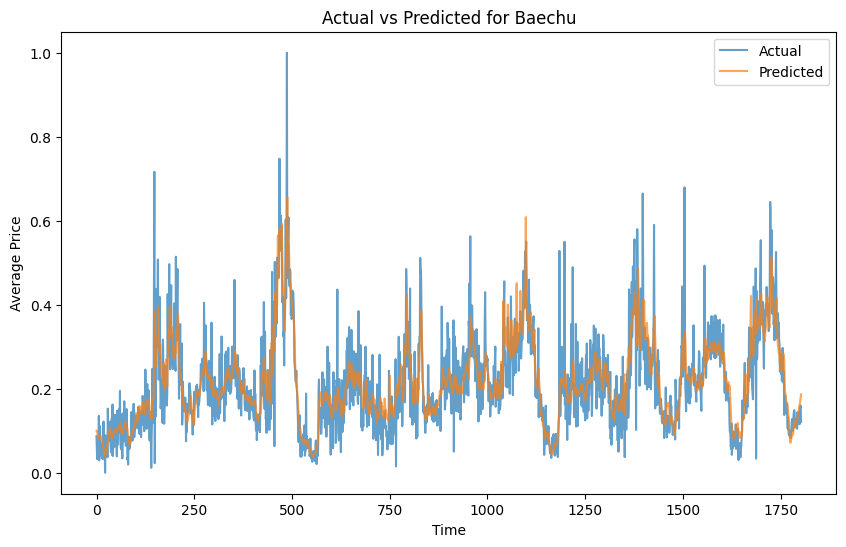

In [39]:
import matplotlib.pyplot as plt

y_pred = model.predict(X_test)

plt.figure(figsize=(10, 6))
plt.plot(y_test.flatten(), label='Actual', alpha=0.7)
plt.plot(y_pred.flatten(), label='Predicted', alpha=0.7)
plt.legend()
plt.title('Actual vs Predicted for Baechu')
plt.xlabel('Time')
plt.ylabel('Average Price')
plt.show()


In [5]:
import shutil

# 저장된 모델 삭제
shutil.rmtree(saved_model_dir)
os.makedirs(saved_model_dir, exist_ok=True)


In [42]:
!pip install --upgrade tensorflow keras


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 615.3/615.3 MB 1.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 67.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 99.0 MB/s eta 0:00:00
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.17.1
    Uninstalling tensorboard-2.17.1:
      Successfully uninstalled tensorboard-2.17.1
  Attempting uninstall: keras
    Found existing installation: keras 3.5.0
    Uninstalling keras-3.5.0:
      Successfully uninstalled keras-3.5.0
  Attempting uninstall: tensorflow
    Found existing installation: tensorflow 2.17.1
    Uninstalling tensorflow-2.17.1:
      Successfully uninstalled tensorflow-2.17.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tf-keras 2.17.0 requires tensorflow<2.18,>=2.17, but you have tensorflow 2.18.0 which is incompat

In [ ]:
# 계절 변수 포함, 불포함 MSE 비교

In [6]:
import os
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Input
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import TimeSeriesSplit

# 데이터 경로 설정
data_dir = '/content/sample_data'
file_path = os.path.join(data_dir, 'daily_average_price_volume_by_product_seoul.csv')

# 모델 저장 경로
saved_model_dir = '/content/saved_models'
os.makedirs(saved_model_dir, exist_ok=True)

# 데이터 로드
if not os.path.exists(file_path):
    raise FileNotFoundError(f"Data file not found at {file_path}")
data = pd.read_csv(file_path)

# 데이터 정렬
data['일자'] = pd.to_datetime(data['일자'])
data = data.sort_values(['품목', '일자'])

# 계절 원핫인코딩
onehot_encoder = OneHotEncoder(sparse_output=False)
seasons_encoded = onehot_encoder.fit_transform(data[['계절']])
season_columns = onehot_encoder.get_feature_names_out(['계절'])
season_df = pd.DataFrame(seasons_encoded, columns=season_columns)

# 원핫인코딩된 계절 추가
data = pd.concat([data.reset_index(drop=True), season_df.reset_index(drop=True)], axis=1)

# 학습 및 성능 비교 함수
def preprocess_and_train(grouped_data, product_name, include_season=True):
    """
    grouped_data: 특정 품목 데이터
    product_name: 품목 이름
    include_season: 계절 변수를 포함할지 여부
    """
    # 필요한 컬럼 선택
    feature_columns = ['총물량', '평균단가', '온도차(°C)', '평균기온(°C)', '일강수량(mm)']
    if include_season:
        feature_columns += list(season_columns)  # 계절 변수 추가

    data_subset = grouped_data[feature_columns]

    # 스케일링
    scaler = MinMaxScaler()
    scaled_data = scaler.fit_transform(data_subset)

    # 시계열 데이터 생성
    def create_sequences(data, seq_length=30):
        X, y = [], []
        for i in range(len(data) - seq_length):
            X.append(data[i:i+seq_length, :])
            y.append(data[i+seq_length, 1])  # 평균단가 예측
        return np.array(X), np.array(y)

    sequence_length = 30
    X, y = create_sequences(scaled_data, sequence_length)

    # TimeSeriesSplit for cross-validation
    tscv = TimeSeriesSplit(n_splits=5)
    fold = 1
    performance = []

    for train_index, test_index in tscv.split(X):
        print(f"Processing fold {fold} for product: {product_name}, include_season={include_season}")
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        # 모델 구성
        model = Sequential([
            Input(shape=(sequence_length, X_train.shape[2])),
            LSTM(50, return_sequences=True),
            LSTM(50, return_sequences=False),
            Dense(25, activation='relu'),
            Dense(1)
        ])

        model.compile(optimizer='adam', loss='mse')

        # 모델 훈련
        model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=50, batch_size=32, verbose=0)

        # 성능 평가
        y_pred = model.predict(X_test)
        mse = mean_squared_error(y_test, y_pred)
        performance.append(mse)
        print(f"Fold {fold} MSE: {mse}")

        fold += 1

    # 평균 MSE 반환
    avg_performance = np.mean(performance)
    print(f"Average MSE for product: {product_name}, include_season={include_season}: {avg_performance}")
    return avg_performance

# 특정 품목만 선택
specific_product = "배추"
grouped = data.groupby('품목')

for product, group in grouped:
    if product == specific_product:  # 특정 품목만 처리
        print(f"Processing product: {product}")

        # 계절 변수를 포함한 모델
        mse_with_season = preprocess_and_train(group, product, include_season=True)

        # 계절 변수를 포함하지 않은 모델
        mse_without_season = preprocess_and_train(group, product, include_season=False)


Processing product: 배추
Processing fold 1 for product: 배추, include_season=True
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step
Fold 1 MSE: 0.012239283835165505
Processing fold 2 for product: 배추, include_season=True
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step
Fold 2 MSE: 0.005823388944969322
Processing fold 3 for product: 배추, include_season=True
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step
Fold 3 MSE: 0.00576907185703689
Processing fold 4 for product: 배추, include_season=True
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step
Fold 4 MSE: 0.005418415052227662
Processing fold 5 for product: 배추, include_season=True
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step
Fold 5 MSE: 0.004280293082387429
Average MSE for product: 배추, include_season=True: 0.006706090554357362
Processing fold 1 for product: 배추, include_season=False
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step
Fold 1 MSE: 0.008084144220500059
Processing fold 2 for product: 배추, include_season=False
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step
Fold 2 MSE: 0.005374959042408589
Processin

계절 변수를 포함한 모델  
Fold MSE:
[0.0122, 0.0058, 0.0058, 0.0054, 0.0043]  
평균 MSE:
0.0067  

계절 변수를 포함하지 않은 모델  
Fold MSE:
[0.0081, 0.0054, 0.0073, 0.0051, 0.0043]  
평균 MSE:
0.0060